Here is My Code

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

First,Calculate the effect size based on our expected rates and Calculating sample size needed
12% is the click rate now and we want to see if the new strategy can boost our click rate to 14%

In [2]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  
# Rounding up to next whole number 
required_n = ceil(required_n)                           

print(required_n)


4433


We'd need at least 4433 observations for each group (Control and Treatment)

Now Let's load our Cleaned data

In [3]:
df = pd.read_csv('/Users/haitonghuang/Downloads/ads_test.csv')
df

,id,user_id,timestamp,group,advertising_pid,clk
0,1,851104,2021-01-21 22:11:48.556739,control,430576_1007,0
1,2,804228,2021-01-12 08:01:45.159739,control,430576_1007,0
2,3,661590,2021-01-11 16:55:06.154213,treatment,430575_1007,0
3,4,853541,2021-01-08 18:28:03.143765,treatment,430575_1007,0
4,5,864975,2021-01-21 01:52:26.210827,control,430576_1007,1
...,...,...,...,...,...,...
294473,294474,751197,2021-01-03 22:28:38.630509,control,430576_1007,0
294474,294475,945152,2021-01-12 00:51:57.078372,control,430576_1007,0
294475,294476,734608,2021-01-22 11:45:03.439544,control,430576_1007,0
294476,294477,697314,2021-01-15 01:20:28.957438,control,430576_1007,0


In [4]:
dic_mapping = {"user_id":'count','clk':{'sum','mean'}}
df.groupby(['advertising_pid']).agg(dic_mapping)

user_id       clk       
                  count      mean    sum
advertising_pid                         
430575_1007      147239  0.122970  18106
430576_1007      147239  0.120478  17739

In [5]:
df.head()

,id,user_id,timestamp,group,advertising_pid,clk
0,1,851104,2021-01-21 22:11:48.556739,control,430576_1007,0
1,2,804228,2021-01-12 08:01:45.159739,control,430576_1007,0
2,3,661590,2021-01-11 16:55:06.154213,treatment,430575_1007,0
3,4,853541,2021-01-08 18:28:03.143765,treatment,430575_1007,0
4,5,864975,2021-01-21 01:52:26.210827,control,430576_1007,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               294478 non-null  int64 
 1   user_id          294478 non-null  int64 
 2   timestamp        294478 non-null  object
 3   group            294478 non-null  object
 4   advertising_pid  294478 non-null  object
 5   clk              294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


There are **294478** rows in the DataFrame, each representing a user session, as well as 5 columns :

* user_id - The user ID of each session
* timestamp - Timestamp for the session
* group - Which group the user was assigned to for that session (control, treatment)
* advertising_pid - Different advertising slot appears on a webpage
* clk - Whether the session ended in a click or not (binary, 0=not clicked, 1=clicked)

In [7]:
pd.crosstab(df['group'], df['advertising_pid'])

advertising_pid,430575_1007,430576_1007
group,,
control,0,147239
treatment,147239,0


It's necessary to remove the **duplicate**

In [8]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [9]:
users_to_drop = session_counts[session_counts > 1].index

In [10]:
df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


Here is the **control group**

In [12]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
control_sample


,id,user_id,timestamp,group,advertising_pid,clk
186628,186629,763854,2021-01-21 03:43:17.188315,control,430576_1007,0
57904,57905,690555,2021-01-18 06:38:13.079449,control,430576_1007,0
13276,13277,861520,2021-01-06 21:13:40.044766,control,430576_1007,0
228415,228416,630778,2021-01-05 16:42:36.995204,control,430576_1007,0
96065,96066,656634,2021-01-04 15:31:21.676130,control,430576_1007,0
...,...,...,...,...,...,...
257296,257297,874529,2021-01-24 07:04:17.537822,control,430576_1007,1
31782,31783,861728,2021-01-23 22:57:52.075095,control,430576_1007,0
265393,265394,751420,2021-01-24 01:06:08.140295,control,430576_1007,0
15579,15580,724889,2021-01-20 10:32:46.460392,control,430576_1007,0


AND **Treatment Group**

In [14]:
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)
treatment_sample

,id,user_id,timestamp,group,advertising_pid,clk
259346,259347,860447,2021-01-11 21:20:47.193292,treatment,430575_1007,0
237647,237648,845654,2021-01-06 21:49:33.725054,treatment,430575_1007,0
73088,73089,833106,2021-01-11 21:56:24.637002,treatment,430575_1007,0
121106,121107,665687,2021-01-08 04:17:45.135586,treatment,430575_1007,0
78032,78033,658409,2021-01-22 13:18:58.765132,treatment,430575_1007,0
...,...,...,...,...,...,...
51081,51082,763303,2021-01-07 14:32:40.875314,treatment,430575_1007,0
199012,199013,890329,2021-01-17 18:51:33.549219,treatment,430575_1007,0
16626,16627,861501,2021-01-07 21:40:37.089854,treatment,430575_1007,0
167041,167042,920507,2021-01-21 04:45:21.873403,treatment,430575_1007,0


Combine two dataframes using **CONCAT**

In [15]:
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,id,user_id,timestamp,group,advertising_pid,clk
0,186629,763854,2021-01-21 03:43:17.188315,control,430576_1007,0
1,57905,690555,2021-01-18 06:38:13.079449,control,430576_1007,0
2,13277,861520,2021-01-06 21:13:40.044766,control,430576_1007,0
3,228416,630778,2021-01-05 16:42:36.995204,control,430576_1007,0
4,96066,656634,2021-01-04 15:31:21.676130,control,430576_1007,0
...,...,...,...,...,...,...
8861,51082,763303,2021-01-07 14:32:40.875314,treatment,430575_1007,0
8862,199013,890329,2021-01-17 18:51:33.549219,treatment,430575_1007,0
8863,16627,861501,2021-01-07 21:40:37.089854,treatment,430575_1007,0
8864,167042,920507,2021-01-21 04:45:21.873403,treatment,430575_1007,0


In [16]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               8866 non-null   int64 
 1   user_id          8866 non-null   int64 
 2   timestamp        8866 non-null   object
 3   group            8866 non-null   object
 4   advertising_pid  8866 non-null   object
 5   clk              8866 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 415.7+ KB


Double Checking the needed observations

In [17]:
ab_test['group'].value_counts()

control      4433
treatment    4433
Name: group, dtype: int64

In [18]:
conversion_rates = ab_test.groupby('group')['clk']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.124,0.330,0.005
treatment,0.128,0.334,0.005


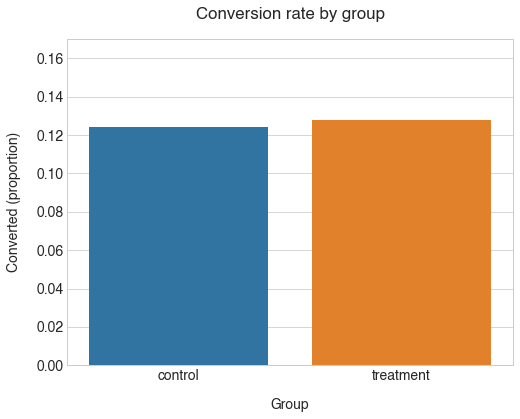

In [61]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['clk'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);


In [62]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['clk']
treatment_results = ab_test[ab_test['group'] == 'treatment']['clk']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.45)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.48
p-value: 0.631
ci 95% for control group: [0.121, 0.128]
ci 95% for treatment group: [0.124, 0.131]


Note that our P-value=0.631 is way above our alpha =0.05, we cannot reject the null hypothesis , which means that the new strategy did not perform significantly different (let alone better) than the old one

Additionally, if we look at the confidence interval for the treatment group (12.4%-13.1%) we notice that:

It includes our baseline value of 12% conversion rate
It does not include our target value of 14% (the 2% uplift we were aiming for)
What this means is that it is more likely that the true click rate of the new strategy is similar to our baseline, rather than the 14% target we had hoped for. This is further proof that our new strategy is not likely to be an improvement on our old one.